[View in Colaboratory](https://colab.research.google.com/github/kmjohnson3/ML4MI_BootCamp/blob/master/MaleFemaleRadiograph/male_female_basic_example.ipynb)

## Setup packages and data
First import the packages you'll need. From Keras, we'll need an data generator package, layers package, a package containing optimizres, and a package that builds/configures models.

In [0]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
from keras import optimizers
from keras.models import Model 
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [5]:
# This is the command to get the data for linux. For windows please manually install and place "data" in the same folder
!wget https://uwmadison.box.com/shared/static/jjg456te6od73pct27jj8sxn12gpi433.zip
!unzip -q -o jjg456te6od73pct27jj8sxn12gpi433.zip  
  

--2018-07-31 21:56:25--  https://uwmadison.box.com/shared/static/jjg456te6od73pct27jj8sxn12gpi433.zip
Resolving uwmadison.box.com (uwmadison.box.com)... 107.152.27.197
Connecting to uwmadison.box.com (uwmadison.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://uwmadison.app.box.com/shared/static/jjg456te6od73pct27jj8sxn12gpi433.zip [following]
--2018-07-31 21:56:25--  https://uwmadison.app.box.com/shared/static/jjg456te6od73pct27jj8sxn12gpi433.zip
Resolving uwmadison.app.box.com (uwmadison.app.box.com)... 107.152.27.199, 107.152.26.199
Connecting to uwmadison.app.box.com (uwmadison.app.box.com)|107.152.27.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!3Cd0n_BvvIRbdV7b4rZjS_RUgqkLrj68pV9HVi5e9lp5wevSGPY4Vn-uemW25fAUyuSmKWC2qISclkS7lXbvF0EoGZ_ydZOKAjfidTGTyW6tAoyijVndrSotbu3fjNKY9qpYlL53B-GQUEjrou7egkiJzQo_s2E-gCaEXZ6H8-TJMgNU5xad05XWkiMRg1HgCUys

jjg456te6od73pct27j 100%[===================>] 220.92M  19.0MB/s    in 12s     

2018-07-31 21:56:38 (18.9 MB/s) - ‘jjg456te6od73pct27jj8sxn12gpi433.zip.2’ saved [231646580/231646580]



Define data location and image dimensions. Data is split into train (50%), validate (25%), and test (25%).
We'll use Kera's ImageDataGenerator method to read in the data. Data (.png files) is sorted into folders with the following structure
train/
    Class1/
            xx1.png
            xx2.png
            ...
    Class2/
            yy1.png
            yy2.png
test/
    Class1/  ...
    Class2/  ...
validation/
    Class1/ ...
    Class2/ ...

We tell Keras where the directories are. It counts the number of subfolders and makes each one a class.

In [0]:
data_home_dir = 'data/'
train_dir = data_home_dir + 'train'
validation_dir = data_home_dir + 'validation'
dims = 256

When we define the ImageDataGenerator object, we tell it to normalize the .png images by the max (255)

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

Keras will read the files continuously from disk. We tell it where to read, how many to read at a time, what dimensions to resample the images to, and how many image channels there are. These generators will then generate batches of images. 

In [8]:
train_generator =      train_datagen.flow_from_directory(train_dir, batch_size=20, target_size=(dims,dims), class_mode='binary', color_mode='grayscale')
validation_generator = valid_datagen.flow_from_directory(validation_dir,batch_size=20, target_size=(dims,dims), class_mode='binary',color_mode='grayscale')

Found 2602 images belonging to 2 classes.
Found 600 images belonging to 2 classes.



## Build network 
First part of the graph is the input, which, at this point, we only need to tell it its shape (we'll define where the inputs come from when we build the model later)

In [0]:
img_input = layers.Input(shape=(dims,dims,1))

Now we build our layers of the network. The format is layer_name(_config_info_)(_input_to_layer_).
Try a simple layer with 1 convolution, max pooling, and a fully-connected layer (these are _not_ the best parameters).

In [0]:
x = layers.Conv2D(15, (3, 3), strides=(4,4), padding='same', kernel_initializer='he_normal')(img_input)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2), strides=None)(x)
x = layers.Flatten()(x)     #reshape to 1xN
x = layers.Dense(20, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dense(1, activation='sigmoid')(x)    #sigmoid for binary

## Configure and train model
We define our model, define the input(s) and output(s). 

In [0]:
model = Model(inputs=img_input, outputs=x)

We then compile it and determine our loss function, our optimizer, and the metrics we want to calculate. This builds the "graph" of our model and computes the functions needed to train it.

In [0]:
model.compile(loss = "binary_crossentropy", optimizer = optimizers.RMSprop(lr=1e-5), metrics=["acc"])

This next steps kicks off the network training. This is where we actually feed the compiled model the data (in batches).

In [13]:
history = model.fit_generator(train_generator, steps_per_epoch=130, epochs=35, 
                              validation_data=validation_generator, validation_steps=30)

Epoch 1/35
130/130 [==============================] - 13s 98ms/step - loss: 0.6802 - acc: 0.5608 - val_loss: 0.6510 - val_acc: 0.6000
Epoch 2/35
130/130 [==============================] - 11s 87ms/step - loss: 0.6448 - acc: 0.6288 - val_loss: 0.6353 - val_acc: 0.6567
Epoch 3/35
130/130 [==============================] - 11s 87ms/step - loss: 0.6295 - acc: 0.6508 - val_loss: 0.6231 - val_acc: 0.6733
Epoch 4/35
 32/130 [======>.......................] - ETA: 6s - loss: 0.6059 - acc: 0.6734

130/130 [==============================] - 11s 87ms/step - loss: 0.6140 - acc: 0.6715 - val_loss: 0.6103 - val_acc: 0.6633
Epoch 5/35
130/130 [==============================] - 11s 87ms/step - loss: 0.6053 - acc: 0.6743 - val_loss: 0.6026 - val_acc: 0.6433
Epoch 6/35
130/130 [==============================] - 11s 86ms/step - loss: 0.5952 - acc: 0.7011 - val_loss: 0.6079 - val_acc: 0.6767
Epoch 7/35
 50/130 [==========>...................] - ETA: 5s - loss: 0.5932 - acc: 0.6830

130/130 [==============================] - 11s 88ms/step - loss: 0.5896 - acc: 0.6935 - val_loss: 0.5952 - val_acc: 0.6350
Epoch 8/35
130/130 [==============================] - 11s 86ms/step - loss: 0.5801 - acc: 0.7081 - val_loss: 0.6053 - val_acc: 0.6833
Epoch 9/35
130/130 [==============================] - 11s 88ms/step - loss: 0.5761 - acc: 0.7169 - val_loss: 0.6055 - val_acc: 0.6850
Epoch 10/35
 57/130 [============>.................] - ETA: 4s - loss: 0.5520 - acc: 0.7430

130/130 [==============================] - 11s 87ms/step - loss: 0.5686 - acc: 0.7230 - val_loss: 0.5883 - val_acc: 0.6683
Epoch 11/35
130/130 [==============================] - 11s 88ms/step - loss: 0.5638 - acc: 0.7200 - val_loss: 0.5877 - val_acc: 0.6733
Epoch 12/35
130/130 [==============================] - 11s 88ms/step - loss: 0.5553 - acc: 0.7323 - val_loss: 0.6052 - val_acc: 0.6900
Epoch 13/35
 62/130 [=============>................] - ETA: 4s - loss: 0.5615 - acc: 0.7161

130/130 [==============================] - 11s 88ms/step - loss: 0.5574 - acc: 0.7285 - val_loss: 0.5800 - val_acc: 0.6600
Epoch 14/35
130/130 [==============================] - 11s 86ms/step - loss: 0.5500 - acc: 0.7296 - val_loss: 0.5878 - val_acc: 0.6917
Epoch 15/35
130/130 [==============================] - 11s 85ms/step - loss: 0.5413 - acc: 0.7446 - val_loss: 0.5788 - val_acc: 0.6900
Epoch 16/35
 62/130 [=============>................] - ETA: 4s - loss: 0.5419 - acc: 0.7476

130/130 [==============================] - 12s 89ms/step - loss: 0.5493 - acc: 0.7404 - val_loss: 0.5736 - val_acc: 0.6850
Epoch 17/35
130/130 [==============================] - 11s 84ms/step - loss: 0.5398 - acc: 0.7435 - val_loss: 0.5711 - val_acc: 0.6617
Epoch 18/35
130/130 [==============================] - 11s 84ms/step - loss: 0.5357 - acc: 0.7408 - val_loss: 0.5668 - val_acc: 0.6783
Epoch 19/35
 65/130 [==============>...............] - ETA: 3s - loss: 0.5250 - acc: 0.7469

130/130 [==============================] - 11s 85ms/step - loss: 0.5317 - acc: 0.7419 - val_loss: 0.5621 - val_acc: 0.6800
Epoch 20/35
130/130 [==============================] - 11s 85ms/step - loss: 0.5257 - acc: 0.7511 - val_loss: 0.5659 - val_acc: 0.6683
Epoch 21/35
130/130 [==============================] - 11s 85ms/step - loss: 0.5267 - acc: 0.7485 - val_loss: 0.5573 - val_acc: 0.6833
Epoch 22/35
 65/130 [==============>...............] - ETA: 4s - loss: 0.5179 - acc: 0.7500

130/130 [==============================] - 11s 85ms/step - loss: 0.5237 - acc: 0.7504 - val_loss: 0.5590 - val_acc: 0.6700
Epoch 23/35
130/130 [==============================] - 11s 86ms/step - loss: 0.5196 - acc: 0.7608 - val_loss: 0.5566 - val_acc: 0.6683
Epoch 24/35
130/130 [==============================] - 11s 86ms/step - loss: 0.5117 - acc: 0.7546 - val_loss: 0.5910 - val_acc: 0.6950
Epoch 25/35
 65/130 [==============>...............] - ETA: 3s - loss: 0.5187 - acc: 0.7677

130/130 [==============================] - 11s 86ms/step - loss: 0.5118 - acc: 0.7715 - val_loss: 0.5533 - val_acc: 0.7067
Epoch 26/35
130/130 [==============================] - 11s 84ms/step - loss: 0.5105 - acc: 0.7577 - val_loss: 0.5596 - val_acc: 0.6800
Epoch 27/35
130/130 [==============================] - 11s 84ms/step - loss: 0.5084 - acc: 0.7765 - val_loss: 0.5455 - val_acc: 0.6967
Epoch 28/35
 65/130 [==============>...............] - ETA: 3s - loss: 0.5101 - acc: 0.7562

130/130 [==============================] - 11s 85ms/step - loss: 0.5082 - acc: 0.7639 - val_loss: 0.5523 - val_acc: 0.7217
Epoch 29/35
130/130 [==============================] - 11s 84ms/step - loss: 0.5142 - acc: 0.7588 - val_loss: 0.5423 - val_acc: 0.7067
Epoch 30/35
130/130 [==============================] - 11s 83ms/step - loss: 0.4901 - acc: 0.7812 - val_loss: 0.5419 - val_acc: 0.6900
Epoch 31/35
 64/130 [=============>................] - ETA: 3s - loss: 0.4941 - acc: 0.7828

130/130 [==============================] - 11s 83ms/step - loss: 0.4956 - acc: 0.7792 - val_loss: 0.5408 - val_acc: 0.7183
Epoch 32/35
130/130 [==============================] - 11s 83ms/step - loss: 0.5027 - acc: 0.7654 - val_loss: 0.5403 - val_acc: 0.6967
Epoch 33/35
130/130 [==============================] - 11s 83ms/step - loss: 0.4920 - acc: 0.7781 - val_loss: 0.5337 - val_acc: 0.7017
Epoch 34/35
 64/130 [=============>................] - ETA: 4s - loss: 0.4981 - acc: 0.7750

130/130 [==============================] - 11s 84ms/step - loss: 0.4951 - acc: 0.7731 - val_loss: 0.5332 - val_acc: 0.7133
Epoch 35/35
130/130 [==============================] - 11s 83ms/step - loss: 0.4890 - acc: 0.7792 - val_loss: 0.5323 - val_acc: 0.7100


## Evaluate performance
First, let's calculate the performance on our testing dataset

In [14]:
test_dir = data_home_dir + 'test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,batch_size=20, target_size=(dims,dims), class_mode='binary',color_mode='grayscale')

#now evaluate the model using the generator
[test_loss, test_acc] = model.evaluate_generator(test_generator, steps=600/20)
print("Test_acc: "+str(test_acc))

Found 601 images belonging to 2 classes.
Test_acc: 0.7516666650772095


Plot the results using matplotlib

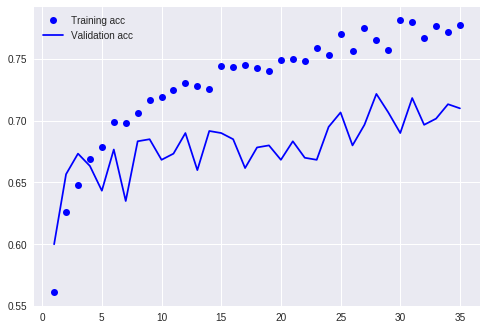

In [15]:
from matplotlib import pyplot as plt
import numpy as np
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'bo', label='Training acc')
plt.plot(epochs,val_acc,'b', label='Validation acc')
plt.legend()
plt.show()